# Pre-processing - making the dataset 

In [1]:
# -*- coding: utf-8 -*-


import os
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Disclaimer. Images are taken from the ImageCEF collaboration from [give link here]()

Plain black-and-white (two level) images should never be converted to JPEG; they violate all of the conditions given above. You need at least about 16 grey levels before JPEG is useful for grey-scale images. It should also be noted that GIF is lossless for grey-scale images of up to 256 levels, while JPEG is not.

References

[Plankton Image Classification](https://benanne.github.io/2015/03/17/plankton.html)
[github](https://github.com/benanne/kaggle-ndsb)

In [2]:
input_filepath = "/Users/ericleijonmarck/dev/dicommunify/data/raw/ImageData.csv"
output_filepath = "/Users/ericleijonmarck/dev/dicommunify/data/processed/prep_imagedata.csv"

In [3]:
df = pd.read_csv(input_filepath, header=None, delimiter=";", names=["image", "class"],encoding='utf-8')

In [4]:
df["class"].unique()

array(['Body', 'Head-Neck', 'Lower-Limb', 'Upper-Limb', 'True-Negative'], dtype=object)

#### Classes
We have now made it possible to attach each image to it's corresponding class

Body - the body of human

Head-Neck - Head and neck

Lower-limb - the lower part of a human body

Upper-limb - upper part of a human body

True-Negative - Image taken with the same x-ray camera that contains non-body parts are considered as true negative.


In [5]:
df.head()

,image,class
0,10.1224.176.125.112.16.201109071451150.jpeg,Body
1,10.1224.176.125.112.16.201109071557120.1.jpeg,Body
2,10.1224.176.125.112.16.201109081127120.1.jpeg,Body
3,10.1224.176.125.112.16.201109081127121.1.jpeg,Body
4,10.1224.176.125.112.16.20110908123224.4.jpeg,Body


# strip whitespaces

In [6]:
df["image"] = df["image"].map(str.strip)

In [7]:
raw_storage = '/users/ericleijonmarck/dev/dicommunify/data/raw/Image_Downscaled/'
'''
project_dir = os.path.join(os.path.dirname(__file__), os.pardir, os.pardir)
data_dir = os.path.join(project_dir,'data')
image_dir = os.path.join(project_dir,'data','raw','Image_Downscaled')
'''

"\nproject_dir = os.path.join(os.path.dirname(__file__), os.pardir, os.pardir)\ndata_dir = os.path.join(project_dir,'data')\nimage_dir = os.path.join(project_dir,'data','raw','Image_Downscaled')\n"

In [8]:
import matplotlib.image as img
image = img.imread(raw_storage + str(df['image'][0]))

In [9]:
image.shape

(1189, 1600, 3)

In [10]:
image[0,0,:]

array([0, 0, 0], dtype=uint8)

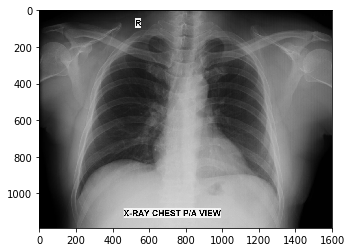

In [11]:
plt.imshow(image)

## Convert image filenames into np.arrays

In [12]:
%cd '/users/ericleijonmarck/dev/dicommunify/data/raw/Image_Downscaled/'
df['image'] = df['image'].map(img.imread)

/Users/ericleijonmarck/dev/dicommunify/data/raw/Image_Downscaled


In [13]:
dimen = []
ratio = []
for i in range(len(df['image'])):
    dimen.append(df['image'][i].shape[0])
    ratio.append((df['image'][i].shape[0] / df['image'][i].shape[1]))
max(dimen)

3768

In [14]:
print("max : %s and ""min : %s",max(ratio), min(ratio))

max : %s and min : %s 2.355 0.553125


In [15]:
df.head()

,image,class
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Body
1,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",Body
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Body
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Body
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",Body


In [26]:
df['image'][0].max()

255

### Resizign of the images to a fixed length

In [16]:
class_dict = {'Body': 0,
 'Head-Neck': 1,
 'Lower-Limb': 2,
 'Upper-Limb': 3,
 'True-Negative': 4}

### creation of the train and test sets of the images

resizing for less of size of the images

In [17]:
train_shuffled_images = []
test_shuffled_images = []

test_percentage = 0.2

for key, value in class_dict.items():
    shuffled = df[df['class'] == key]['image'].tolist()
    print(len(shuffled))
    np.random.shuffle(shuffled)

    k = int(len(shuffled) * test_percentage)
    print(k)
    test_shuffled_images = test_shuffled_images + shuffled[0:k]
    train_shuffled_images = train_shuffled_images + shuffled[k:]

100
20
100
20
100
20
100
20
100
20


### Resizing of the miages for test and training

In [18]:
import scipy.misc

In [19]:
train_images = [scipy.misc.imresize(image, (100,50)) for image in train_shuffled_images]
test_images = [scipy.misc.imresize(image, (100,50)) for image in test_shuffled_images]

### Keras implementation


* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

# preprocessing of the images - Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [21]:
import os
import errno

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

### Train datagenerator augmentation

generate more training samples

In [22]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory

train_datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
rescale=1./256,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

counter = 0
class_counter = 0
first = True
class_feature = ['Body','Head-Neck','Lower-Limb','Upper-Limb','True-Negative']

train_dir = '../../processed/train'
make_sure_path_exists(train_dir)

for image in train_images:
    counter += 1
    
    if (counter % 100 == 0) and (first == False) != (counter == 500):
        print(counter)
        class_counter += 1
    first = False

    train_class_dir = os.path.join(train_dir,class_feature[class_counter])
    make_sure_path_exists(train_class_dir)
    
    i = 0
    prefix = class_feature[class_counter] + '_'
    # making it into the correct array format
    image_reshaped = image.reshape((1,) + image.shape)
    for batch in train_datagen.flow(image_reshaped, batch_size=1,save_to_dir=train_class_dir, save_prefix=prefix, save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely



100
200
300
400


### Test datagenerator augmentator

generate augmentated images for more test samples

In [23]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory


# only rescaling augmentation for test samples
test_datagen = ImageDataGenerator(rescale=1./256)

counter = 0
class_counter = 0
first = True
class_feature = ['Body','Head-Neck','Lower-Limb','Upper-Limb','True-Negative']

test_dir = '../../processed/test'
make_sure_path_exists(test_dir)

for image in test_images:
    counter += 1
    
    if (counter % 100 == 0) and (first == False) != (counter == 500):
        print(counter)
        class_counter += 1
    first = False
    
    test_class_dir = os.path.join(test_dir,class_feature[class_counter])
    make_sure_path_exists(test_class_dir)

    i = 0
    prefix = class_feature[class_counter] + '_'
    # making it into the correct array format
    image_reshaped = image.reshape((1,) + image.shape)
    for batch in test_datagen.flow(image_reshaped, batch_size=1,save_to_dir=test_class_dir, save_prefix=prefix, save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

100
